In [1]:
from __future__ import annotations
import numpy as np
import random
import copy
import importlib

from typing import Tuple, List
from numpy import array, zeros
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, plot_functions, figure_plots, colors

## colors

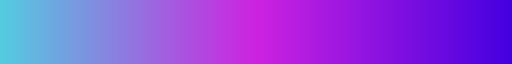

In [2]:
colors_lst, red, cmap = colors.color_scheme()
cmap

# Parameters

In [3]:
## Parameters

## task type
task_type='Regression'


# ## task matrix X
# M_values: np.ndarray = array([0.15, 0.2, 0.015, 0.1, 0.01, 0.03, 0.05, 0.12, 0.23, 0.25, 0.12, 0.1, 0.02, 0.3, 0.35, 0.25,
#                               0.03, 0.02, 0.25, 0.31, 0.02, 0.08, 0.35, 0.1, 0.03, 0.2, 0.1, 0.18, 0.12, 0.35, 0.05, 0.15,
#                               0.25, 0.25, 0.02, 0.01, 0.08, 0.07, 0.35, 0.15, 0.01, 0.25, 0.13, 0.05, 0.03, 0.3, 0.32, 0.05,
#                               0.15, 0.12, 0.25, 0.1, 0.25, 0.3, 0.25, 0.25, 0.04, 0.27, 0.1, 0.11, 0.02, 0.2, 0.4, 0.15,
#                               ])

## specify # of nodes
Nin: int = 0
extraNin: int = 0
Ninter: int = 0
Nout: int = 0
extraNout: int = 0

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

## method to update resistances - physical property of the system
R_update: str = 'R_propto_dp'
# R_update: str = 'deltaR_propto_dp'
# R_update: str = 'deltaR_propto_Q'
# R_update: str = 'deltaR_propto_Power'
R_vec_i = array([1.])

alpha: float = 0.1  # for network combine attempt
stay_sample: int = 2

# length of training dataset
iterations = int(2e4)  # number of sampled of p

stay_sample = 2

random_state = 42

# measure accuracy every # steps
measure_accuracy_every = 15

supress_prints: bool = True  # whether to print information during training or not
bc_noise: float = 0.0  # noise to dual problem
use_p_tag: bool = False  # use 1 or 2 sampled pressures at every time step
include_Power: bool = False
lam: float = 0
    
access_interNodes: bool = False  # access and change pressure at interNodes (nodes between input and output) or not
noise_to_extra: bool = False  # add noise to extra outputs 

In [4]:
def network_build_given_Nin_Nout(Nin: int, Nout: int, M_values: NDArray[np.float_]) -> tuple():
    
    # initialize Variables
    Variabs = User_Variables(iterations,\
                             Nin, \
                             extraNin, \
                             Ninter, \
                             Nout, \
                             extraNout, \
                             gamma, \
                             R_update, \
                             use_p_tag, \
                             include_Power, lam, \
                             supress_prints, \
                             bc_noise, \
                             access_interNodes, \
                             task_type, \
                             measure_accuracy_every)
    
    Variabs.assign_alpha_vec(alpha)
    
    # Normalize M
    # M_values_norm = normalize([M_values[:Nin*Nout]], norm="l1")[0]/2  # normalize Nin*Nout values of M to norm of 0.5
    M_mat = M_values[0:Nout*Nin].reshape(Nout, Nin)
    M_line = np.sum(M_mat, axis=1)
    M_values_norm = M_values[:Nin*Nout]/np.max(M_line)*0.75  # normalize so max sum over line will be 0.75
    # M_values_norm = copy.copy(M_values[:Nin*Nout])  # don't normalize
    print('M_norm', M_values_norm)
    Variabs.create_dataset_and_targets(random_state, M_values_norm)
    Variabs.create_noise_for_extras()
    BigClass = Big_Class(Variabs)
        
    # initialize Structure
    inInterOutGround_tuple = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs.extraNin, Variabs.Ninter, 
                                                                            Variabs.Nout, Variabs.extraNout)
        
    
    Strctr = Network_Structure(inInterOutGround_tuple)
    Strctr.build_incidence()
    Strctr.build_edges()
    BigClass.add_Strctr(Strctr)  # add to big class
    
    # initialize State    
    State = Network_State(Variabs)
    State.initiate_resistances(BigClass, R_vec_i)
    State.initiate_accuracy_vec(BigClass, measure_accuracy_every)
    BigClass.add_State(State)  # add to big class
    
    return Variabs, Strctr, State, BigClass


def random_gen_M(random_state: int, size: NDArray[np.int_]) -> NDArray[np.float_]:
    """
    random_gen_M generates a random M_values array for regression task
    use for multiple_Nin_Nout for example, and before train_loop()
    
    inputs:
    random_state - int, random seed
    size         - size of M_values, train_loop then decides how many to take
    """
    # generate random state
    random_gen = np.random.RandomState(random_state)

    # Generate random values with the defined random state
    M_values = random_gen.rand(size)
    
    return M_values


def train_loop(Variabs, Strctr, State, BigClass):
    loss_mean = [1, 1]
    for l in range(Variabs.iterations):
        
        k = (l//stay_sample)*2 + l%2

        # draw input and desired outputs from dataset
        if not((l+1) % 4):  # add noise only at i=3 etc.
            State.draw_p_in_and_desired(Variabs, k, noise_to_extra=False)  # add noise to extra nodes every 2nd iteration
            State.solve_flow_given_problem(BigClass, "measure", noise_to_extra=False)  # measure and don't change resistances
        else:  # dont add noise to extra nodes
            State.draw_p_in_and_desired(Variabs, k)
            State.solve_flow_given_problem(BigClass, "measure")

        if not l % 2:  # even iterations, take another sampled pressure and measure again
            pass
        else:  # odd iterations, go to dual problem and update resistances
            State.t += 1
            State.calc_loss(BigClass)
            State.update_input_dual(BigClass)
            State.update_output_dual(BigClass)
            State.solve_flow_given_problem(BigClass, "dual", access_inters=False)  # measure and don't change resistances
            State.update_Rs(BigClass)
            
#         if not (l+1)%window_for_mean:
#             # print('l', l)
#             loss_mean.append(np.mean(np.mean(np.abs(State.loss_in_t[-window_for_mean:]), axis=1)))
#             # print(loss_mean)
            
#         if loss_mean[-1]<10e-8 or (loss_mean[-1]-loss_mean[-2])>0 or loss_mean[-1]>2:
#             break
            
    return State

# Loop

In [5]:
# window_for_mean = 1000
# n = 10
# random_state_M_vec = array([42, 43, 44, 45, 46, 47, 48, 49]) 
# norm_mean_loss = np.zeros([n,n, np.shape(random_state_M_vec)[0]])

# for k, random_state_M in enumerate(random_state_M_vec):
#     M_values = random_gen_M(random_state_M, n*n)
#     for i in range(n):
#         for j in range(n):
#             Nin: int = i + 1
#             Nout: int = j + 1
#             print('Nin', Nin)
#             print('Nout', Nout)

#             Variabs, Strctr, State, BigClass = network_build_given_Nin_Nout(Nin, Nout, M_values)
#             State = train_loop(Variabs, Strctr, State, BigClass)

#             norm_mean_loss_ij = np.mean(np.mean(np.abs(State.loss_norm_in_t[-window_for_mean:]), axis=1))
#             # norm_mean_loss_ij = mean_loss_ij / np.mean(Variabs.targets)
#             print('norm_mean_loss_ij', norm_mean_loss_ij)

#             norm_mean_loss[i, j, k] = norm_mean_loss_ij
#             # plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M, include_network=True)

In [6]:
window_for_mean = 1000
n = 10
random_state_M_vec = array([42, 43, 44, 45, 46, 47, 48, 49]) 
# random_state_M_vec = array([42]) 
norm_mean_loss = np.zeros([n,n, np.shape(random_state_M_vec)[0]])
Nin_vec = np.linspace(1,n,n).astype(np.int32)
Nout_vec = np.linspace(1,n,n).astype(np.int32)
alpha1: float = 0.2  # for network combine attempt

for k, random_state_M in enumerate(random_state_M_vec):
    M_values = random_gen_M(random_state_M, 10*10)
    for i, Nin in enumerate(Nin_vec):
        for j, Nout in enumerate(Nout_vec):
            alpha: float = copy.copy(alpha1)
            print('iteration out of 8: ', k)
            print('Nin', Nin)
            print('Nout', Nout)
            Variabs, Strctr, State, BigClass = network_build_given_Nin_Nout(Nin, Nout, M_values)
            State = train_loop(Variabs, Strctr, State, BigClass)

            norm_mean_loss_ij = np.mean(np.mean(np.abs(State.loss_norm_in_t[-window_for_mean:]), axis=1))
            print('norm_mean_loss_ij', norm_mean_loss_ij)
            
            # if loss too big decrease alpha and calculate again
            if norm_mean_loss_ij > 0.3:
                print('too big loss, decreasing alpha')
                alpha = alpha / 4
                print('new alpha', alpha)
                Variabs, Strctr, State, BigClass = network_build_given_Nin_Nout(Nin, Nout, M_values)
                State = train_loop(Variabs, Strctr, State, BigClass)
                norm_mean_loss_ij = np.mean(np.mean(np.abs(State.loss_norm_in_t[-window_for_mean:]), axis=1))
                print('norm_mean_loss_ij', norm_mean_loss_ij)

            norm_mean_loss[i, j, k] = norm_mean_loss_ij
            # plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M, include_network=True)

iteration out of 8:  0
Nin 1
Nout 1
M_norm [0.75]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.0
iteration out of 8:  0
Nin 1
Nout 2
M_norm [0.29546741 0.75      ]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 1.607373182519936e-16
iteration out of 8:  0
Nin 1
Nout 3
M_norm [0.29546741 0.75       0.57745576]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 1.0494875166423188e-16
iteration out of 8:  0
Nin 1
Nout 4
M_norm [0.29546741 0.75       0.57745576 0.47227002]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 2.144182212638265e-16
iteration out of 8:  0
Nin 1
Nout 5
M_norm [0.29546741 0.75       0.57745576 0.47227002 0.12308007]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 1.189329670722616e-16
iteration out of 8:  0
Nin 1
Nout 6
M_norm [0.29546741 0.75       0.57745576 0.47227002 0.12308007 0.12306104]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 3.1127253350916837e-16
itera

norm_mean_loss_ij 0.17774731580746933
iteration out of 8:  0
Nin 3
Nout 7
M_norm [0.13654408 0.34659681 0.2668591  0.21824971 0.05687888 0.05687009
 0.02117523 0.31577719 0.21914527 0.25813822 0.00750438 0.35359483
 0.30347915 0.07741133 0.06628695 0.0668628  0.11091596 0.19130764
 0.15747188 0.10617185 0.22305993]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.16151296196825266
iteration out of 8:  0
Nin 3
Nout 8
M_norm [0.13654408 0.34659681 0.2668591  0.21824971 0.05687888 0.05687009
 0.02117523 0.31577719 0.21914527 0.25813822 0.00750438 0.35359483
 0.30347915 0.07741133 0.06628695 0.0668628  0.11091596 0.19130764
 0.15747188 0.10617185 0.22305993 0.05085453 0.10650561 0.13356257]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.15521156124982108
iteration out of 8:  0
Nin 3
Nout 9
M_norm [0.13654408 0.34659681 0.2668591  0.21824971 0.05687888 0.05687009
 0.02117523 0.31577719 0.21914527 0.25813822 0.00750438 0.35359483
 0.30347915 0.07741133 0.0

norm_mean_loss_ij 0.11960528013591588
iteration out of 8:  0
Nin 5
Nout 7
M_norm [0.09989777 0.25357561 0.19523827 0.15967488 0.04161347 0.04160704
 0.01549213 0.2310275  0.16033009 0.18885793 0.00549032 0.25869547
 0.22203006 0.05663533 0.04849656 0.04891786 0.08114784 0.13996364
 0.11520887 0.07767697 0.16319411 0.03720596 0.07792116 0.09771645
 0.12164351 0.20942304 0.05325722 0.1371572  0.15800949 0.01238931
 0.16204506 0.04548239 0.01735064 0.25308784 0.25755449]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.13096504529527475
iteration out of 8:  0
Nin 5
Nout 8
M_norm [0.09989777 0.25357561 0.19523827 0.15967488 0.04161347 0.04160704
 0.01549213 0.2310275  0.16033009 0.18885793 0.00549032 0.25869547
 0.22203006 0.05663533 0.04849656 0.04891786 0.08114784 0.13996364
 0.11520887 0.07767697 0.16319411 0.03720596 0.07792116 0.09771645
 0.12164351 0.20942304 0.05325722 0.1371572  0.15800949 0.01238931
 0.16204506 0.04548239 0.01735064 0.25308784 0.25755449 0.2156166

norm_mean_loss_ij 0.09826108816142251
iteration out of 8:  0
Nin 7
Nout 4
M_norm [0.06671316 0.16934142 0.13038291 0.10663317 0.02779007 0.02778577
 0.01034586 0.15428347 0.10707072 0.12612203 0.00366651 0.17276053
 0.14827485 0.03782188 0.0323867  0.03266805 0.05419169 0.09346972
 0.07693813 0.05187379 0.10898336 0.02484667 0.05203686 0.06525644
 0.08123528 0.1398557  0.03556593 0.09159554]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.09687232375963031
iteration out of 8:  0
Nin 7
Nout 5
M_norm [0.06671316 0.16934142 0.13038291 0.10663317 0.02779007 0.02778577
 0.01034586 0.15428347 0.10707072 0.12612203 0.00366651 0.17276053
 0.14827485 0.03782188 0.0323867  0.03266805 0.05419169 0.09346972
 0.07693813 0.05187379 0.10898336 0.02484667 0.05203686 0.06525644
 0.08123528 0.1398557  0.03556593 0.09159554 0.105521   0.00827376
 0.10821601 0.03037379 0.011587   0.16901568 0.17199857]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.10768589000535075
it

norm_mean_loss_ij 0.09238665732814771
iteration out of 8:  0
Nin 8
Nout 9
M_norm [0.04817953 0.12229656 0.09416114 0.07700933 0.02006969 0.02006659
 0.00747167 0.11142186 0.07732533 0.09108398 0.00264792 0.1247658
 0.1070825  0.02731456 0.02338933 0.02359251 0.03913666 0.06750283
 0.05556389 0.0374627  0.07870661 0.017944   0.03758046 0.0471275
 0.05866724 0.10100228 0.02568534 0.06614932 0.07620613 0.00597522
 0.07815244 0.02193563 0.00836801 0.12206131 0.12421552 0.1039894
 0.03918445 0.0125642  0.08801734 0.05661967 0.01569857 0.06369782
 0.00442362 0.11697179 0.03328855 0.08522455 0.04009742 0.06689973
 0.07032689 0.02377903 0.12472397 0.09971037 0.12085385 0.11510745
 0.07691176 0.11858667 0.01138337 0.02521055 0.00581788 0.04184935
 0.04999808 0.03490539 0.10660589 0.0458915  0.03613843 0.06981052
 0.018128   0.10319181 0.00958993 0.12694968 0.09933886 0.02556209]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.0960468792485603
iteration out of 8:  0
Nin 8
Nout 

norm_mean_loss_ij 0.09159146992913778
iteration out of 8:  0
Nin 10
Nout 1
M_norm [0.05400601 0.13708621 0.10554829 0.08632227 0.02249677 0.02249329
 0.00837524 0.12489641 0.08667649 0.10209901]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.0031327420743575626
iteration out of 8:  0
Nin 10
Nout 2
M_norm [0.05400601 0.13708621 0.10554829 0.08632227 0.02249677 0.02249329
 0.00837524 0.12489641 0.08667649 0.10209901 0.00296814 0.13985407
 0.12003228 0.03061778 0.02621786 0.02644562 0.04386956 0.07566613
 0.06228338 0.04199316]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.043870734947879526
iteration out of 8:  0
Nin 10
Nout 3
M_norm [0.05400601 0.13708621 0.10554829 0.08632227 0.02249677 0.02249329
 0.00837524 0.12489641 0.08667649 0.10209901 0.00296814 0.13985407
 0.12003228 0.03061778 0.02621786 0.02644562 0.04386956 0.07566613
 0.06228338 0.04199316 0.08822481 0.02011402 0.04212517 0.05282676
 0.06576203 0.11321676 0.02879153 0.07414893 0.085421

norm_mean_loss_ij 3.626887916855434e-16
iteration out of 8:  1
Nin 1
Nout 6
M_norm [0.10043902 0.53169593 0.11644612 0.21002717 0.2855821  0.75      ]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 3.679884138381587e-16
iteration out of 8:  1
Nin 1
Nout 7
M_norm [0.10043902 0.53169593 0.11644612 0.21002717 0.2855821  0.75
 0.5814758 ]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 4.3198059487465213e-16
iteration out of 8:  1
Nin 1
Nout 8
M_norm [0.10043902 0.53169593 0.11644612 0.21002717 0.2855821  0.75
 0.5814758  0.47241759]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 3.5684456182402747e-16
iteration out of 8:  1
Nin 1
Nout 9
M_norm [0.10043902 0.53169593 0.11644612 0.21002717 0.2855821  0.75
 0.5814758  0.47241759 0.02532816]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 2.0659006139533292e-10
iteration out of 8:  1
Nin 1
Nout 10
M_norm [0.10043902 0.53169593 0.11644612 0.21002717 0.2855821  0.75
 0.5814758  0

norm_mean_loss_ij 0.15694072212546997
iteration out of 8:  1
Nin 3
Nout 10
M_norm [0.03733388 0.19763508 0.04328383 0.07806856 0.10615285 0.27878022
 0.2161386  0.1756009  0.00941465 0.23809287 0.12815673 0.26025505
 0.08255672 0.01845851 0.2812175  0.07172136 0.13141441 0.10256966
 0.02487616 0.2736167  0.27547097 0.31522923 0.12505037 0.3097204
 0.14464345 0.21731793 0.02677032 0.29109815 0.0966987  0.08511489]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.1596813569178416
iteration out of 8:  1
Nin 4
Nout 1
M_norm [0.07858191 0.41599053 0.09110561 0.16432195]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 5.009335039540195e-12
iteration out of 8:  1
Nin 4
Nout 2
M_norm [0.03605176 0.19084787 0.04179737 0.07538752 0.10250734 0.26920632
 0.20871594 0.1695704 ]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 2.7464670468404764
too big loss, decreasing alpha
new alpha 0.05
M_norm [0.03605176 0.19084787 0.04179737 0.07538752 0.10250734

norm_mean_loss_ij 0.11928988171334791
iteration out of 8:  1
Nin 6
Nout 1
M_norm [0.03777436 0.19996684 0.04379451 0.07898964 0.10740528 0.28206936]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 1.6010208438392002e-05
iteration out of 8:  1
Nin 6
Nout 2
M_norm [0.0272468  0.14423689 0.03158916 0.05697554 0.07747186 0.20345776
 0.15774102 0.12815603 0.00687095 0.17376356 0.0935306  0.18993783]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.07690071719693553
iteration out of 8:  1
Nin 6
Nout 3
M_norm [0.0272468  0.14423689 0.03158916 0.05697554 0.07747186 0.20345776
 0.15774102 0.12815603 0.00687095 0.17376356 0.0935306  0.18993783
 0.06025107 0.01347128 0.20523653 0.05234327 0.0959081  0.0748568 ]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.1190927425066543
iteration out of 8:  1
Nin 6
Nout 4
M_norm [0.02114892 0.11195646 0.02451946 0.04422433 0.06013355 0.15792362
 0.12243835 0.09947453 0.00533322 0.13487502 0.07259832 0.147429

norm_mean_loss_ij 0.09506312216827402
iteration out of 8:  1
Nin 7
Nout 9
M_norm [0.01958304 0.10366709 0.02270401 0.04094992 0.0556812  0.1462308
 0.1133729  0.09210934 0.00493834 0.12488874 0.06722307 0.13651365
 0.04330413 0.00968219 0.14750925 0.03762058 0.06893184 0.05380168
 0.01304849 0.14352234 0.14449498 0.16534969 0.06559366 0.1624601
 0.07587098 0.1139915  0.01404205 0.15269202 0.05072214 0.04464599
 0.00087308 0.09245661 0.0809496  0.10831495 0.16649672 0.15466032
 0.15491398 0.08940194 0.0177047  0.03079284 0.16221366 0.07011708
 0.14723155 0.11440895 0.10702344 0.0469019  0.15263223 0.03521426
 0.06883241 0.16911251 0.12522554 0.07575235 0.09542853 0.06999836
 0.12373809 0.06794591 0.11406307 0.11994719 0.10375106 0.09191739
 0.03507647 0.03389858 0.13543994]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.09195059911649973
iteration out of 8:  1
Nin 7
Nout 10
M_norm [0.01958304 0.10366709 0.02270401 0.04094992 0.0556812  0.1462308
 0.1133729  0.09210934

norm_mean_loss_ij 0.07341001568300558
iteration out of 8:  1
Nin 9
Nout 3
M_norm [0.01634874 0.08654563 0.01895426 0.03418671 0.04648499 0.12207959
 0.09464843 0.07689672 0.00412273 0.10426234 0.05612063 0.1139673
 0.0361521  0.00808309 0.12314689 0.03140723 0.05754719 0.04491589
 0.01089343 0.11981845 0.12063045 0.13804084 0.05476033 0.13562848
 0.06334027 0.09516487 0.01172289]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.07068011914728373
iteration out of 8:  1
Nin 9
Nout 4
M_norm [0.01634874 0.08654563 0.01895426 0.03418671 0.04648499 0.12207959
 0.09464843 0.07689672 0.00412273 0.10426234 0.05612063 0.1139673
 0.0361521  0.00808309 0.12314689 0.03140723 0.05754719 0.04491589
 0.01089343 0.11981845 0.12063045 0.13804084 0.05476033 0.13562848
 0.06334027 0.09516487 0.01172289 0.12747369 0.04234496 0.03727234
 0.00072889 0.07718664 0.06758011 0.09042585 0.13899842 0.12911691]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.08792699502386614
iter

norm_mean_loss_ij 0.08144237708519707
iteration out of 8:  1
Nin 10
Nout 6
M_norm [0.01367928 0.07241426 0.01585936 0.02860462 0.03889482 0.10214615
 0.07919402 0.06434085 0.00344956 0.08723815 0.04695712 0.09535846
 0.0302491  0.00676327 0.10303918 0.02627899 0.04815075 0.03758192
 0.00911472 0.10025422 0.10093363 0.11550121 0.04581894 0.11348276
 0.05299792 0.07962614 0.00980875 0.10665949 0.03543078 0.03118643
 0.00060987 0.06458343 0.05654548 0.07566091 0.11630245 0.1080344
 0.10821159 0.06244966 0.01236721 0.02150963 0.11331061 0.04897867
 0.10284521 0.07991774 0.07475876 0.03276224 0.10661773 0.02459811
 0.04808129 0.11812965 0.08747342 0.05291506 0.0666594  0.04889574
 0.08643439 0.04746205 0.07967613 0.08378634 0.07247291 0.06420677]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.07485619230308695
iteration out of 8:  1
Nin 10
Nout 7
M_norm [0.01367928 0.07241426 0.01585936 0.02860462 0.03889482 0.10214615
 0.07919402 0.06434085 0.00344956 0.08723815 0.046957

norm_mean_loss_ij 0.9977165405977332
too big loss, decreasing alpha
new alpha 0.05
M_norm [0.51320143 0.06442117 0.45775188 0.22161021 0.22087868 0.37451632
 0.24206759 0.25146867 0.31345165 0.43654835]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.1297056779124739
iteration out of 8:  2
Nin 2
Nout 6
M_norm [0.44182535 0.05546147 0.39408772 0.19078865 0.19015886 0.32242857
 0.20840082 0.2164944  0.26985677 0.37583318 0.50834141 0.24165859]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.11329099524265901
iteration out of 8:  2
Nin 2
Nout 7
M_norm [0.44182535 0.05546147 0.39408772 0.19078865 0.19015886 0.32242857
 0.20840082 0.2164944  0.26985677 0.37583318 0.50834141 0.24165859
 0.22632695 0.06004864]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.11627442481330906
iteration out of 8:  2
Nin 2
Nout 8
M_norm [0.44182535 0.05546147 0.39408772 0.19078865 0.19015886 0.32242857
 0.20840082 0.2164944  0.26985677 0.37583318 0.50834141 0

norm_mean_loss_ij 0.1276597602403906
iteration out of 8:  2
Nin 5
Nout 1
M_norm [0.26044429 0.03269306 0.23230423 0.11246483 0.11209359]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.00011024023812644887
iteration out of 8:  2
Nin 5
Nout 2
M_norm [0.23787921 0.02986051 0.21217722 0.1027208  0.10238172 0.17359587
 0.11220321 0.1165608  0.14529116 0.20234896]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.06882252941485081
iteration out of 8:  2
Nin 5
Nout 3
M_norm [0.23787921 0.02986051 0.21217722 0.1027208  0.10238172 0.17359587
 0.11220321 0.1165608  0.14529116 0.20234896 0.27369152 0.13010923
 0.12185466 0.03233025 0.06208792]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.08723932250765017
iteration out of 8:  2
Nin 5
Nout 4
M_norm [0.17187807 0.02157552 0.15330727 0.07422024 0.07397525 0.12543056
 0.0810717  0.08422025 0.10497918 0.14620592 0.19775403 0.09400958
 0.08804529 0.02336001 0.04486122 0.19712523 0.19421792 0.18155

norm_mean_loss_ij 0.09995355627262018
iteration out of 8:  2
Nin 6
Nout 10
M_norm [0.13099538 0.01644359 0.11684181 0.05656632 0.05637959 0.09559582
 0.06178809 0.06418773 0.08000897 0.11142958 0.15071652 0.07164858
 0.06710296 0.01780363 0.03419059 0.15023729 0.1480215  0.13836737
 0.10142852 0.03355133 0.09992554 0.02183349 0.07197542 0.13711819
 0.04055353 0.10432203 0.13536254 0.0233558  0.08833268 0.02497311
 0.02712901 0.01632228 0.03184301 0.07142392 0.12467704 0.15547035
 0.12631554 0.05922039 0.08092455 0.00924185 0.11157828 0.01137723
 0.1384909  0.113926   0.1307638  0.11144255 0.10943398 0.14594277
 0.13834359 0.01490209 0.07162902 0.07731342 0.01709907 0.02412253
 0.15444437 0.0426106  0.14077243 0.02577012 0.02076839 0.04979604]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.10391225906846453
iteration out of 8:  2
Nin 7
Nout 1
M_norm [0.18377215 0.02306856 0.16391623 0.07935633 0.07909438 0.13411044
 0.08668191]
R_vec_i has wrong size, initializing all

norm_mean_loss_ij 0.08010445018990253
iteration out of 8:  2
Nin 8
Nout 6
M_norm [0.11254473 0.01412752 0.10038468 0.04859897 0.04843855 0.08213117
 0.05308526 0.05514691 0.06873973 0.09573476 0.12948814 0.0615569
 0.05765153 0.01529599 0.02937486 0.12907641 0.12717272 0.11887837
 0.08714234 0.02882563 0.08585106 0.01875825 0.06183771 0.11780514
 0.03484158 0.0896283  0.11629677 0.02006615 0.07589105 0.02145566
 0.02330789 0.01402329 0.02735793 0.06136388 0.10711632 0.1335724
 0.10852404 0.05087922 0.06952635 0.00794014 0.09586252 0.00977475
 0.1189845  0.09787956 0.11234576 0.09574591 0.09402024 0.12538678]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.07729738473419533
iteration out of 8:  2
Nin 8
Nout 7
M_norm [0.11254473 0.01412752 0.10038468 0.04859897 0.04843855 0.08213117
 0.05308526 0.05514691 0.06873973 0.09573476 0.12948814 0.0615569
 0.05765153 0.01529599 0.02937486 0.12907641 0.12717272 0.11887837
 0.08714234 0.02882563 0.08585106 0.01875825 0.06183771 0

norm_mean_loss_ij 0.08210184478132856
iteration out of 8:  2
Nin 9
Nout 9
M_norm [0.11044918 0.01386447 0.09851555 0.04769407 0.04753664 0.08060192
 0.05209683 0.05412009 0.06745982 0.09395221 0.12707712 0.06041074
 0.05657807 0.01501119 0.02882791 0.12667306 0.12480481 0.11666489
 0.08551978 0.02828891 0.08425254 0.01840898 0.06068631 0.11561165
 0.03419284 0.08795946 0.11413137 0.01969252 0.07447799 0.02105616
 0.02287391 0.01376218 0.02684854 0.06022131 0.10512185 0.13108533
 0.10650336 0.04993186 0.06823179 0.0077923  0.09407759 0.00959275
 0.11676905 0.09605707 0.11025392 0.09396315 0.09226962 0.12305212
 0.11664485 0.01256474 0.06039424 0.06518706 0.01441714 0.02033899
 0.13022027 0.03592727 0.11869273 0.02172816 0.01751093 0.04198569
 0.04067184 0.05583768 0.04379065 0.07515608 0.01260611 0.10557201
 0.0355431  0.12057972 0.11930026 0.00209798 0.11294172 0.08938235
 0.00498508 0.04087364 0.07464991 0.07859616 0.09007126 0.0836704
 0.12418985 0.09752054 0.098544  ]
R_vec_i has wr

norm_mean_loss_ij 0.0794995767445034
iteration out of 8:  2
Nin 10
Nout 10
M_norm [0.09573809 0.01201782 0.08539393 0.04134154 0.04120507 0.06986628
 0.04515788 0.04691166 0.05847462 0.0814384  0.11015129 0.05236443
 0.04904225 0.0130118  0.02498822 0.10980105 0.10818164 0.10112591
 0.07412912 0.02452102 0.07303067 0.01595702 0.0526033  0.10021294
 0.02963858 0.07624384 0.09892983 0.01706961 0.06455802 0.01825162
 0.01982726 0.01192915 0.02327249 0.05220023 0.09112032 0.11362563
 0.09231782 0.04328127 0.05914377 0.00675441 0.08154708 0.00831506
 0.10121619 0.08326291 0.09556883 0.08144788 0.07997992 0.10666239
 0.10110853 0.0108912  0.05235013 0.05650458 0.01249687 0.01762997
 0.11287579 0.03114199 0.10288365 0.01883411 0.01517859 0.03639348
 0.03525463 0.04840047 0.03795803 0.06514579 0.01092706 0.09151052
 0.03080899 0.1045193  0.10341026 0.00181854 0.09789863 0.07747721
 0.0043211  0.03542954 0.06470704 0.06812768 0.07807437 0.07252606
 0.10764859 0.08453145 0.08541859 0.01248679 0.

norm_mean_loss_ij 0.11683260131227421
iteration out of 8:  3
Nin 3
Nout 10
M_norm [0.3476435  0.19316828 0.09893042 0.02716775 0.1562337  0.16619484
 0.01705578 0.05740953 0.04075737 0.22053195 0.30095314 0.22851491
 0.34824463 0.16533112 0.21733423 0.09935922 0.34307104 0.23658745
 0.15484926 0.10182684 0.1791625  0.03953068 0.07977597 0.16821401
 0.08533095 0.13637819 0.28783893 0.02620153 0.32449262 0.07905233]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.12902437858147306
iteration out of 8:  3
Nin 4
Nout 1
M_norm [0.39095627 0.21723504 0.11125612 0.03055257]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.00018794822811986434
iteration out of 8:  3
Nin 4
Nout 2
M_norm [0.39095627 0.21723504 0.11125612 0.03055257 0.1756988  0.186901
 0.01918075 0.06456216]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.05210141204077524
iteration out of 8:  3
Nin 4
Nout 3
M_norm [0.32972519 0.18321196 0.09383133 0.02576746 0.14818107 0.15762

norm_mean_loss_ij 0.10980570884828836
iteration out of 8:  3
Nin 5
Nout 10
M_norm [0.20686859 0.11494663 0.05886949 0.01616643 0.09296836 0.09889583
 0.0101492  0.03416209 0.02425306 0.13122965 0.17908504 0.13597998
 0.2072263  0.09838186 0.12932681 0.05912466 0.2041477  0.14078362
 0.09214453 0.06059304 0.10661236 0.02352311 0.04747146 0.10009736
 0.050777   0.08115315 0.17128131 0.01559147 0.19309243 0.04704084
 0.14774962 0.02312665 0.12571024 0.08508758 0.17503712 0.05229812
 0.09574369 0.11659653 0.05269967 0.02305885 0.15198853 0.06485724
 0.17272049 0.09447374 0.01969076 0.18557365 0.1551505  0.02550421
 0.17901958 0.01400128]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.11539634138183014
iteration out of 8:  3
Nin 6
Nout 1
M_norm [0.26354238 0.14643745 0.0749974  0.02059539 0.118438   0.12598937]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.00099779682517127
iteration out of 8:  3
Nin 6
Nout 2
M_norm [0.26354238 0.14643745 0.0749974  0.

norm_mean_loss_ij 0.10293734964956122
iteration out of 8:  3
Nin 7
Nout 8
M_norm [0.18645031 0.1036012  0.05305897 0.01457077 0.08379222 0.08913465
 0.00914746 0.03079023 0.02185925 0.11827706 0.16140905 0.12255853
 0.18677271 0.08867141 0.11656204 0.05328895 0.18399798 0.12688804
 0.08304971 0.0546124  0.09608954 0.02120134 0.04278594 0.09021758
 0.04576522 0.07314319 0.15437556 0.01405257 0.17403388 0.04239783
 0.13316648 0.02084401 0.11330243 0.07668929 0.15776066 0.04713621
 0.08629363 0.10508826 0.04749812 0.0207829  0.13698701 0.05845572
 0.15567269 0.08514902 0.01774725 0.16725722 0.13983688 0.0229869
 0.16135004 0.01261933 0.03467897 0.03245721 0.17386957 0.12561825
 0.04808378 0.04737861]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.10731273486634027
iteration out of 8:  3
Nin 7
Nout 9
M_norm [0.18645031 0.1036012  0.05305897 0.01457077 0.08379222 0.08913465
 0.00914746 0.03079023 0.02185925 0.11827706 0.16140905 0.12255853
 0.18677271 0.08867141 0.1165620

norm_mean_loss_ij 0.09726702164578968
iteration out of 8:  3
Nin 9
Nout 1
M_norm [0.23605087 0.13116178 0.06717402 0.01844697 0.1060831  0.11284675
 0.01158092 0.03898122 0.02767437]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.002041608412020657
iteration out of 8:  3
Nin 9
Nout 2
M_norm [0.12071359 0.06707456 0.03435199 0.00943356 0.05424963 0.05770848
 0.00592234 0.01993453 0.01415234 0.07657616 0.10450112 0.07934811
 0.12092232 0.05740856 0.0754658  0.03450089 0.11912588 0.08215117]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.06992398460288243
iteration out of 8:  3
Nin 9
Nout 3
M_norm [0.12071359 0.06707456 0.03435199 0.00943356 0.05424963 0.05770848
 0.00592234 0.01993453 0.01415234 0.07657616 0.10450112 0.07934811
 0.12092232 0.05740856 0.0754658  0.03450089 0.11912588 0.08215117
 0.0537689  0.03535773 0.06221129 0.01372639 0.02770092 0.0584096
 0.02962979 0.04735512 0.09994742]
R_vec_i has wrong size, initializing all ones
norm_mean_lo

norm_mean_loss_ij 0.0741633354120465
iteration out of 8:  3
Nin 10
Nout 5
M_norm [0.11872682 0.06597061 0.03378661 0.0092783  0.05335676 0.05675868
 0.00582487 0.01960644 0.01391941 0.07531583 0.10278118 0.07804216
 0.11893212 0.0564637  0.07422374 0.03393305 0.11716524 0.08079908
 0.05288395 0.03477579 0.06118738 0.01350047 0.027245   0.05744826
 0.02914213 0.04657573 0.09830243 0.00894832 0.11082036 0.02699786
 0.08479703 0.01327293 0.07214811 0.04883379 0.10045798 0.03001514
 0.05494959 0.06691753 0.0302456  0.01323402 0.08722985 0.03722312
 0.09912841 0.05422073 0.011301   0.10650515 0.08904457 0.01463747
 0.10274361 0.00803567]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.07623584637842605
iteration out of 8:  3
Nin 10
Nout 6
M_norm [0.11872682 0.06597061 0.03378661 0.0092783  0.05335676 0.05675868
 0.00582487 0.01960644 0.01391941 0.07531583 0.10278118 0.07804216
 0.11893212 0.0564637  0.07422374 0.03393305 0.11716524 0.08079908
 0.05288395 0.03477579 0.06118

norm_mean_loss_ij 6.606299254459432
too big loss, decreasing alpha
new alpha 0.05
M_norm [0.41438523 0.33561477 0.13166053 0.40076866 0.16551302 0.49548519]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.12752053934597127
iteration out of 8:  4
Nin 2
Nout 4
M_norm [0.41438523 0.33561477 0.13166053 0.40076866 0.16551302 0.49548519
 0.02266149 0.23307134]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 3.6331236947350107
too big loss, decreasing alpha
new alpha 0.05
M_norm [0.41438523 0.33561477 0.13166053 0.40076866 0.16551302 0.49548519
 0.02266149 0.23307134]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.13846633446333198
iteration out of 8:  4
Nin 2
Nout 5
M_norm [0.41438523 0.33561477 0.13166053 0.40076866 0.16551302 0.49548519
 0.02266149 0.23307134 0.48252491 0.24054494]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 7.608504683332893
too big loss, decreasing alpha
new alpha 0.05
M_norm [0.41438523 0.33561477 

norm_mean_loss_ij 3.0920100910787567
too big loss, decreasing alpha
new alpha 0.05
M_norm [0.24234393 0.19627678 0.07699871 0.23438058 0.09679658 0.28977342
 0.01325306 0.13630656 0.28219389 0.14067732 0.15704226 0.02625169
 0.13181809 0.23055948 0.26808272 0.10007044]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.11860710465862942
iteration out of 8:  4
Nin 4
Nout 5
M_norm [0.24234393 0.19627678 0.07699871 0.23438058 0.09679658 0.28977342
 0.01325306 0.13630656 0.28219389 0.14067732 0.15704226 0.02625169
 0.13181809 0.23055948 0.26808272 0.10007044 0.03217754 0.24799437
 0.12207346 0.19409225]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.9360710986568546
too big loss, decreasing alpha
new alpha 0.05
M_norm [0.24234393 0.19627678 0.07699871 0.23438058 0.09679658 0.28977342
 0.01325306 0.13630656 0.28219389 0.14067732 0.15704226 0.02625169
 0.13181809 0.23055948 0.26808272 0.10007044 0.03217754 0.24799437
 0.12207346 0.19409225]
R_vec_i has wrong

norm_mean_loss_ij 0.123722790504423
iteration out of 8:  4
Nin 6
Nout 1
M_norm [0.15991795 0.12951916 0.05080992 0.1546631  0.06387415 0.19121573]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 3.121650415076156e-07
iteration out of 8:  4
Nin 6
Nout 2
M_norm [0.15991795 0.12951916 0.05080992 0.1546631  0.06387415 0.19121573
 0.00874543 0.08994599 0.18621415 0.09283017 0.10362907 0.01732297]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.11383580598341686
iteration out of 8:  4
Nin 6
Nout 3
M_norm [0.15991795 0.12951916 0.05080992 0.1546631  0.06387415 0.19121573
 0.00874543 0.08994599 0.18621415 0.09283017 0.10362907 0.01732297
 0.08698414 0.15214162 0.17690247 0.0660345  0.02123332 0.16364657]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.1003414184633358
iteration out of 8:  4
Nin 6
Nout 4
M_norm [0.15991795 0.12951916 0.05080992 0.1546631  0.06387415 0.19121573
 0.00874543 0.08994599 0.18621415 0.09283017 0.10362907 0.01732297


norm_mean_loss_ij 0.12438246655663704
iteration out of 8:  4
Nin 7
Nout 9
M_norm [0.15807471 0.1280263  0.05022428 0.15288042 0.06313792 0.18901175
 0.00864463 0.08890926 0.18406782 0.0917602  0.10243462 0.0171233
 0.08598155 0.15038801 0.17486346 0.06527337 0.02098858 0.16176035
 0.07962537 0.12660138 0.00725777 0.06048212 0.00961018 0.07506345
 0.05292102 0.19975846 0.07968858 0.06202114 0.04458925 0.09962955
 0.01167163 0.05842353 0.04738222 0.19429407 0.12416235 0.17395647
 0.01816741 0.03004645 0.13563754 0.19743235 0.00468346 0.18305814
 0.01170715 0.15239431 0.0130284  0.05157351 0.03420463 0.03935113
 0.02148922 0.10502713 0.00125968 0.15944056 0.0279737  0.02160787
 0.08663725 0.04416005 0.1685654  0.00118475 0.02991213 0.14083432
 0.02976835 0.17561027 0.1036551 ]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.12192049753472227
iteration out of 8:  4
Nin 7
Nout 10
M_norm [0.15807471 0.1280263  0.05022428 0.15288042 0.06313792 0.18901175
 0.00864463 0.088909

norm_mean_loss_ij 0.0402037837404854
iteration out of 8:  4
Nin 9
Nout 3
M_norm [0.11589314 0.09386302 0.03682214 0.11208493 0.04628984 0.13857477
 0.00633785 0.0651842  0.1349501  0.06727438 0.07510038 0.01255402
 0.06303774 0.11025761 0.12820189 0.04785545 0.01538787 0.11859529
 0.05837768 0.09281834 0.00532107 0.04434273 0.00704574 0.05503308
 0.03879927 0.14645376 0.05842402]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.06822082217002276
iteration out of 8:  4
Nin 9
Nout 4
M_norm [0.11589314 0.09386302 0.03682214 0.11208493 0.04628984 0.13857477
 0.00633785 0.0651842  0.1349501  0.06727438 0.07510038 0.01255402
 0.06303774 0.11025761 0.12820189 0.04785545 0.01538787 0.11859529
 0.05837768 0.09281834 0.00532107 0.04434273 0.00704574 0.05503308
 0.03879927 0.14645376 0.05842402 0.04547107 0.0326908  0.07304383
 0.00855711 0.04283346 0.03473847 0.14244753 0.09103016 0.12753693]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.08521047436877058
ite

norm_mean_loss_ij 0.08156904423464646
iteration out of 8:  4
Nin 10
Nout 6
M_norm [0.10635334 0.08613664 0.03379111 0.1028586  0.04247946 0.12716791
 0.00581615 0.05981853 0.12384161 0.06173665 0.06891845 0.01152063
 0.05784875 0.1011817  0.11764888 0.0439162  0.01412121 0.10883305
 0.05357229 0.08517795 0.00488306 0.04069263 0.00646577 0.05050301
 0.03560549 0.13439834 0.05361482 0.04172809 0.02999984 0.06703118
 0.00785272 0.0393076  0.03187896 0.13072188 0.08353696 0.11703866
 0.01222311 0.02021538 0.09125752 0.13283333 0.00315105 0.1231623
 0.00787662 0.10253154 0.00876556 0.03469888 0.02301302 0.02647561
 0.01445804 0.0706627  0.00084752 0.10727229 0.01882082 0.01453787
 0.05828991 0.02971107 0.11341152 0.0007971  0.02012501 0.09475393]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.09309512926986581
iteration out of 8:  4
Nin 10
Nout 7
M_norm [0.10635334 0.08613664 0.03379111 0.1028586  0.04247946 0.12716791
 0.00581615 0.05981853 0.12384161 0.06173665 0.068918

norm_mean_loss_ij 0.13846921138173007
iteration out of 8:  5
Nin 2
Nout 6
M_norm [0.0564728  0.48491083 0.36262437 0.17489328 0.35211015 0.39788985
 0.3212369  0.20630818 0.35132686 0.12273477 0.12738395 0.01194825]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.14539789323029478
iteration out of 8:  5
Nin 2
Nout 7
M_norm [0.0564728  0.48491083 0.36262437 0.17489328 0.35211015 0.39788985
 0.3212369  0.20630818 0.35132686 0.12273477 0.12738395 0.01194825
 0.04912685 0.14949965]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.14776357907710636
iteration out of 8:  5
Nin 2
Nout 8
M_norm [0.0564728  0.48491083 0.36262437 0.17489328 0.35211015 0.39788985
 0.3212369  0.20630818 0.35132686 0.12273477 0.12738395 0.01194825
 0.04912685 0.14949965 0.31889507 0.16033333]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.14334927325228392
iteration out of 8:  5
Nin 2
Nout 9
M_norm [0.0564728  0.48491083 0.36262437 0.17489328 0.35211015 0.3978898

norm_mean_loss_ij 0.1310864732155121
iteration out of 8:  5
Nin 4
Nout 10
M_norm [0.02798952 0.24033552 0.17972689 0.08668206 0.17451575 0.19720546
 0.1592141  0.10225217 0.17412753 0.06083082 0.06313509 0.00592189
 0.02434866 0.07409625 0.15805342 0.07946574 0.04574818 0.22620627
 0.06681685 0.06746477 0.23538558 0.0313501  0.18429698 0.00129183
 0.21130917 0.17164279 0.13639202 0.23065601 0.12642769 0.04380424
 0.13240653 0.07237562 0.00261477 0.21797064 0.16188972 0.23238739
 0.18372491 0.06590177 0.08924578 0.12982632]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.1286352695494686
iteration out of 8:  5
Nin 5
Nout 1
M_norm [0.02959767 0.25414411 0.19005318 0.09166241 0.18454263]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.00021701872467515455
iteration out of 8:  5
Nin 5
Nout 2
M_norm [0.02959767 0.25414411 0.19005318 0.09166241 0.18454263 0.20853599
 0.16836181 0.10812712 0.1841321  0.06432588]
R_vec_i has wrong size, initializing all ones

norm_mean_loss_ij 0.12062039035436743
iteration out of 8:  5
Nin 6
Nout 9
M_norm [0.02281179 0.19587632 0.14647956 0.07064691 0.14223242 0.16072481
 0.12976139 0.08333674 0.14191601 0.04957785 0.05145585 0.00482641
 0.01984445 0.06038933 0.12881542 0.06476552 0.03728531 0.18436081
 0.05445653 0.05498459 0.19184206 0.02555071 0.15020424 0.00105286
 0.1722195  0.13989092 0.11116113 0.1879874  0.10304007 0.03570098
 0.1079129  0.05898699 0.00213107 0.17764868 0.13194205 0.18939849
 0.14973799 0.05371073 0.07273638 0.10581    0.10992681 0.05199412
 0.03510284 0.07250469 0.02817739 0.07820689 0.09485208 0.1947394
 0.02925984 0.10336795 0.10606084 0.06135538 0.03209548 0.11998241]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.11809310774012599
iteration out of 8:  5
Nin 6
Nout 10
M_norm [0.02281179 0.19587632 0.14647956 0.07064691 0.14223242 0.16072481
 0.12976139 0.08333674 0.14191601 0.04957785 0.05145585 0.00482641
 0.01984445 0.06038933 0.12881542 0.06476552 0.0372853

norm_mean_loss_ij 0.08450448999059211
iteration out of 8:  5
Nin 8
Nout 5
M_norm [0.01797393 0.15433541 0.11541458 0.05566431 0.11206816 0.12663873
 0.10224195 0.06566292 0.11181886 0.03906351 0.04054324 0.00380284
 0.01563589 0.04758213 0.1014966  0.05103023 0.02937795 0.14526208
 0.04290754 0.04332361 0.15115673 0.02013199 0.11834934 0.00082957
 0.13569566 0.11022324 0.08758638 0.14811955 0.08118762 0.02812961
 0.08502703 0.0464772  0.00167912 0.13997344 0.10396015 0.14923139
 0.11798197 0.04231991 0.05731065 0.08337011]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.08164183205421138
iteration out of 8:  5
Nin 8
Nout 6
M_norm [0.01797393 0.15433541 0.11541458 0.05566431 0.11206816 0.12663873
 0.10224195 0.06566292 0.11181886 0.03906351 0.04054324 0.00380284
 0.01563589 0.04758213 0.1014966  0.05103023 0.02937795 0.14526208
 0.04290754 0.04332361 0.15115673 0.02013199 0.11834934 0.00082957
 0.13569566 0.11022324 0.08758638 0.14811955 0.08118762 0.02812961
 0.085027

norm_mean_loss_ij 0.08262498987432472
iteration out of 8:  5
Nin 9
Nout 8
M_norm [0.01564186 0.13431078 0.10043983 0.048442   0.0975276  0.11020767
 0.08897631 0.05714332 0.09731064 0.03399512 0.03528285 0.00330943
 0.01360717 0.04140847 0.08832767 0.04440918 0.02556623 0.12641469
 0.03734039 0.03770248 0.13154452 0.01751991 0.1029938  0.00072194
 0.11808949 0.09592205 0.07622227 0.12890141 0.07065373 0.02447986
 0.07399498 0.0404469  0.00146126 0.12181223 0.09047158 0.12986898
 0.10267411 0.036829   0.04987473 0.07255304 0.0753759  0.03565194
 0.02406973 0.04971587 0.019321   0.05362582 0.06503929 0.1335312
 0.02006323 0.07087855 0.07272504 0.04207088 0.02200761 0.08227095
 0.0142967  0.07828147 0.05324372 0.01167705 0.07745906 0.08932224
 0.09123284 0.0260829  0.13150265 0.00813521 0.12131681 0.10802359
 0.03479838 0.12777877 0.06129896 0.05198191 0.12319365 0.10392952]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.07962172719928003
iteration out of 8:  5
Nin 9
No

norm_mean_loss_ij 0.07626323772067646
iteration out of 8:  5
Nin 10
Nout 10
M_norm [0.01373347 0.11792413 0.08818562 0.04253182 0.0856287  0.09676174
 0.07812072 0.05017152 0.08543821 0.02984753 0.03097815 0.00290566
 0.01194702 0.03635641 0.07755122 0.03899102 0.02244701 0.11099141
 0.03278466 0.03310257 0.11549537 0.01538239 0.090428   0.00063386
 0.10368193 0.08421904 0.06692274 0.11317474 0.06203359 0.02149319
 0.06496719 0.03551215 0.00128298 0.10695048 0.07943355 0.11402426
 0.09014731 0.03233567 0.04378974 0.06370118 0.06617963 0.03130221
 0.02113309 0.04365026 0.01696373 0.04708318 0.05710414 0.11723967
 0.01761541 0.06223098 0.06385219 0.036938   0.01932256 0.07223345
 0.01255243 0.0687307  0.0467477  0.01025238 0.06800863 0.07842444
 0.08010194 0.02290065 0.11545862 0.00714267 0.1065155  0.09484413
 0.03055279 0.11218906 0.05382015 0.04563983 0.10816335 0.09124955
 0.0937187  0.1063754  0.05826513 0.03665462 0.05359958 0.0639104
 0.07359279 0.06356094 0.11834587 0.07285404 0.

norm_mean_loss_ij 0.1245378290376043
iteration out of 8:  6
Nin 3
Nout 6
M_norm [0.00705081 0.35941783 0.11483541 0.12052564 0.3192909  0.13080307
 0.34858866 0.18040471 0.22100663 0.1439859  0.04527608 0.05720267
 0.1793753  0.29508146 0.18547952 0.23895166 0.13573866 0.18319242]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.1244772269213252
iteration out of 8:  6
Nin 3
Nout 7
M_norm [0.00705081 0.35941783 0.11483541 0.12052564 0.3192909  0.13080307
 0.34858866 0.18040471 0.22100663 0.1439859  0.04527608 0.05720267
 0.1793753  0.29508146 0.18547952 0.23895166 0.13573866 0.18319242
 0.07543638 0.16481278 0.05325398]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.12388326768268423
iteration out of 8:  6
Nin 3
Nout 8
M_norm [0.00705081 0.35941783 0.11483541 0.12052564 0.3192909  0.13080307
 0.34858866 0.18040471 0.22100663 0.1439859  0.04527608 0.05720267
 0.1793753  0.29508146 0.18547952 0.23895166 0.13573866 0.18319242
 0.07543638 0.16481278 0.053

norm_mean_loss_ij 0.11217500377996373
iteration out of 8:  6
Nin 5
Nout 7
M_norm [0.00516019 0.26304281 0.08404321 0.08820765 0.2336756  0.09572927
 0.2551174  0.13203063 0.16174547 0.10537723 0.03313566 0.04186423
 0.13127725 0.21595773 0.13574467 0.17487868 0.09934143 0.13407083
 0.05520872 0.12061955 0.03897435 0.01094874 0.02418905 0.06297166
 0.16086018 0.19326566 0.17371139 0.16963867 0.09874294 0.11228112
 0.11849693 0.20042269 0.04312675 0.23271673 0.01104219]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.11609491018420454
iteration out of 8:  6
Nin 5
Nout 8
M_norm [0.00509888 0.25991737 0.08304462 0.08715958 0.2308991  0.09459183
 0.25208613 0.13046186 0.15982363 0.10412516 0.03274195 0.0413668
 0.12971743 0.21339175 0.13413177 0.1728008  0.09816107 0.13247782
 0.05455273 0.11918636 0.03851127 0.01081865 0.02390164 0.06222344
 0.15894886 0.1909693  0.17164737 0.16762304 0.09756969 0.11094701
 0.11708897 0.1980413  0.04261432 0.22995163 0.01091098 0.17888962

norm_mean_loss_ij 0.08075373711372574
iteration out of 8:  6
Nin 7
Nout 4
M_norm [0.00377584 0.19247483 0.06149647 0.06454369 0.17098613 0.07004744
 0.18667561 0.09661003 0.1183531  0.07710709 0.02424617 0.03063308
 0.09605876 0.15802153 0.09932768 0.12796299 0.07269054 0.09810289
 0.04039756 0.08826026 0.02851848 0.00801146 0.01769972 0.04607789
 0.11770531 0.14141719 0.12710885 0.12412874]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.09077533685999034
iteration out of 8:  6
Nin 7
Nout 5
M_norm [0.00377584 0.19247483 0.06149647 0.06454369 0.17098613 0.07004744
 0.18667561 0.09661003 0.1183531  0.07710709 0.02424617 0.03063308
 0.09605876 0.15802153 0.09932768 0.12796299 0.07269054 0.09810289
 0.04039756 0.08826026 0.02851848 0.00801146 0.01769972 0.04607789
 0.11770531 0.14141719 0.12710885 0.12412874 0.07225261 0.08215883
 0.08670709 0.14665416 0.03155689 0.1702845  0.00807984]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.10073118684868312
it

norm_mean_loss_ij 0.08318282014915238
iteration out of 8:  6
Nin 8
Nout 8
M_norm [0.00264885 0.13502611 0.04314137 0.04527908 0.11995123 0.0491401
 0.13095781 0.06777445 0.08302778 0.05409263 0.01700932 0.0214899
 0.06738773 0.11085622 0.06968096 0.08976937 0.05099431 0.06882174
 0.02833994 0.06191687 0.02000646 0.00562025 0.01241681 0.03232484
 0.08257335 0.09920785 0.08917017 0.08707955 0.05068709 0.05763656
 0.06082729 0.10288172 0.02213798 0.11945902 0.00566822 0.09293249
 0.02303022 0.11689848 0.03984859 0.11691244 0.0435338  0.0986949
 0.14396385 0.1391002  0.02495595 0.05115785 0.01364037 0.1049283
 0.10297105 0.13769043 0.04635429 0.02757964 0.005267   0.05606554
 0.14582037 0.08772498 0.13472126 0.0784041  0.11026871 0.05797223
 0.15019839 0.05946351 0.02160626 0.13736554]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.08335463272437649
iteration out of 8:  6
Nin 8
Nout 9
M_norm [2.64884938e-03 1.35026113e-01 4.31413745e-02 4.52790810e-02
 1.19951227e-01 4.9

norm_mean_loss_ij 0.0869790032632912
iteration out of 8:  6
Nin 9
Nout 9
M_norm [2.34777174e-03 1.19678565e-01 3.82377724e-02 4.01324996e-02
 1.06317144e-01 4.35546655e-02 1.16072679e-01 6.00709684e-02
 7.35905514e-02 4.79442726e-02 1.50759814e-02 1.90472824e-02
 5.97281970e-02 9.82559101e-02 6.17607736e-02 7.95658672e-02
 4.51981152e-02 6.09992150e-02 2.51187245e-02 5.48791820e-02
 1.77324547e-02 4.98142935e-03 1.10054734e-02 2.86506875e-02
 7.31877661e-02 8.79315288e-02 7.90347752e-02 7.71817786e-02
 4.49258182e-02 5.10853846e-02 5.39134397e-02 9.11878181e-02
 1.96217012e-02 1.05880881e-01 5.02394640e-03 8.23694550e-02
 2.04125222e-02 1.03611381e-01 3.53192612e-02 1.03623755e-01
 3.85855945e-02 8.74768850e-02 1.27600403e-01 1.23289577e-01
 2.21193694e-02 4.53430671e-02 1.20899601e-02 9.30017760e-02
 9.12669968e-02 1.22040046e-01 4.10854988e-02 2.44448390e-02
 4.66833009e-03 4.96929335e-02 1.29245904e-01 7.77538465e-02
 1.19408365e-01 6.94924071e-02 9.77351795e-02 5.13829016e-02
 1.33

norm_mean_loss_ij 0.09010803512765438
iteration out of 8:  6
Nin 10
Nout 9
M_norm [2.30833409e-03 1.17668215e-01 3.75954578e-02 3.94583575e-02
 1.04531238e-01 4.28230382e-02 1.14122901e-01 5.90619017e-02
 7.23543841e-02 4.71389090e-02 1.48227365e-02 1.87273279e-02
 5.87248881e-02 9.66054163e-02 6.07233217e-02 7.82293270e-02
 4.44388813e-02 5.99745557e-02 2.46967825e-02 5.39573265e-02
 1.74345865e-02 4.89775175e-03 1.08206045e-02 2.81694158e-02
 7.19583647e-02 8.64544630e-02 7.77071562e-02 7.58852861e-02
 4.41711584e-02 5.02272570e-02 5.30078066e-02 8.96560535e-02
 1.92920976e-02 1.04102304e-01 4.93955460e-03 8.09858204e-02
 2.00696345e-02 1.01870927e-01 3.47259714e-02 1.01883092e-01
 3.79374371e-02 8.60074563e-02 1.25456983e-01 1.21218570e-01
 2.17478103e-02 4.45813984e-02 1.18868740e-02 9.14395406e-02
 8.97339021e-02 1.19990028e-01 4.03953483e-02 2.40342168e-02
 4.58991191e-03 4.88581961e-02 1.27074843e-01 7.64477445e-02
 1.17402554e-01 6.83250800e-02 9.60934329e-02 5.05197763e-02
 1.

norm_mean_loss_ij 2.8755367497653777
too big loss, decreasing alpha
new alpha 0.05
M_norm [0.10539128 0.08651574 0.32438265 0.31222035 0.23926883 0.19851082]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.12209659348243239
iteration out of 8:  7
Nin 3
Nout 3
M_norm [0.10539128 0.08651574 0.32438265 0.31222035 0.23926883 0.19851082
 0.19153569 0.0736859  0.26955146]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 4.043591368475398
too big loss, decreasing alpha
new alpha 0.05
M_norm [0.10539128 0.08651574 0.32438265 0.31222035 0.23926883 0.19851082
 0.19153569 0.0736859  0.26955146]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.11201517813767059
iteration out of 8:  7
Nin 3
Nout 4
M_norm [0.10539128 0.08651574 0.32438265 0.31222035 0.23926883 0.19851082
 0.19153569 0.0736859  0.26955146 0.31384051 0.25270647 0.17466215]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 4.345237896789049
too big loss, decreasing alpha
n

norm_mean_loss_ij 0.07199625856335293
iteration out of 8:  7
Nin 5
Nout 3
M_norm [0.06819631 0.05598238 0.20990067 0.20203072 0.15482544 0.12845186
 0.12393841 0.04768048 0.17442065 0.20307909 0.16352064 0.11301992
 0.10020213 0.1818248  0.1914325 ]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.06002968176392286
iteration out of 8:  7
Nin 5
Nout 4
M_norm [0.06819631 0.05598238 0.20990067 0.20203072 0.15482544 0.12845186
 0.12393841 0.04768048 0.17442065 0.20307909 0.16352064 0.11301992
 0.10020213 0.1818248  0.1914325  0.05192102 0.21802002 0.01335046
 0.06567511 0.07073408]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.08772194610048331
iteration out of 8:  7
Nin 5
Nout 5
M_norm [0.06810888 0.0559106  0.20963156 0.20177171 0.15462695 0.12828717
 0.12377951 0.04761935 0.17419703 0.20281873 0.16331099 0.11287503
 0.10007367 0.18159169 0.19118708 0.05185445 0.21774051 0.01333334
 0.06559091 0.07064339 0.15884284 0.16013335 0.21340936 0.13722577
 0.

norm_mean_loss_ij 0.09240420850190974
iteration out of 8:  7
Nin 7
Nout 1
M_norm [0.05422012 0.04450931 0.16688349 0.16062642 0.12309542 0.10212685
 0.09853839]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 2.0058783585877305e-06
iteration out of 8:  7
Nin 7
Nout 2
M_norm [0.05199223 0.04268044 0.16002629 0.15402632 0.11803746 0.09793049
 0.09448948 0.03635115 0.13297666 0.15482559 0.12466659 0.08616533
 0.07639316 0.13862152]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.03817091621672512
iteration out of 8:  7
Nin 7
Nout 3
M_norm [0.05199223 0.04268044 0.16002629 0.15402632 0.11803746 0.09793049
 0.09448948 0.03635115 0.13297666 0.15482559 0.12466659 0.08616533
 0.07639316 0.13862152 0.14594634 0.03958409 0.16621641 0.01017826
 0.05007009 0.053927   0.12125575]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.07072610088512774
iteration out of 8:  7
Nin 7
Nout 4
M_norm [0.05199223 0.04268044 0.16002629 0.15402632 0.11803746 0.097

norm_mean_loss_ij 0.06734530417454579
iteration out of 8:  7
Nin 8
Nout 7
M_norm [0.03614025 0.02966755 0.11123568 0.10706505 0.08204887 0.06807234
 0.06568046 0.025268   0.09243324 0.10762062 0.08665684 0.05989428
 0.05310156 0.09635703 0.10144858 0.02751525 0.11553849 0.007075
 0.03480416 0.03748513 0.08428593 0.08497071 0.11324028 0.07281538
 0.04265621 0.05053019 0.1088538  0.030252   0.03637513 0.00913191
 0.03019965 0.10935046 0.10130593 0.07651524 0.11889352 0.11286692
 0.10266219 0.1106125  0.07994504 0.04719867 0.06998037 0.04532017
 0.05768135 0.04340198 0.02000647 0.10746586 0.06521213 0.09886322
 0.06818656 0.00080112 0.07538971 0.09229641 0.03841043 0.00329734
 0.01090156 0.03071844]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.07269998923720607
iteration out of 8:  7
Nin 8
Nout 8
M_norm [0.03614025 0.02966755 0.11123568 0.10706505 0.08204887 0.06807234
 0.06568046 0.025268   0.09243324 0.10762062 0.08665684 0.05989428
 0.05310156 0.09635703 0.10144858

norm_mean_loss_ij 0.07897358997334021
iteration out of 8:  7
Nin 9
Nout 10
M_norm [0.03812592 0.03129758 0.11734733 0.11294755 0.08655691 0.07181246
 0.06928916 0.02665631 0.09751183 0.11353365 0.09141805 0.06318506
 0.05601913 0.1016512  0.1070225  0.02902703 0.12188655 0.00746372
 0.03671641 0.03954468 0.08891688 0.08963928 0.11946207 0.07681609
 0.04499989 0.05330648 0.11483458 0.03191415 0.0383737  0.00963365
 0.03185892 0.11535853 0.10687201 0.08071924 0.12542592 0.11906819
 0.10830279 0.11668992 0.08433748 0.04979192 0.07382532 0.04781021
 0.06085055 0.04578663 0.02110569 0.11337039 0.0687951  0.10429509
 0.07193295 0.00084514 0.07953187 0.09736747 0.04052083 0.0034785
 0.01150053 0.03240621 0.07818341 0.10529908 0.00128802 0.08678858
 0.01736411 0.11764044 0.07876432 0.12536556 0.03437302 0.07528604
 0.0662224  0.09302316 0.07951951 0.07609483 0.12286607 0.0772494
 0.0843314  0.09646068 0.00833348 0.11089686 0.09010896 0.11399248
 0.06717682 0.00067101 0.10189019 0.07174527 0.11

norm_mean_loss_ij 0.0719539593778752


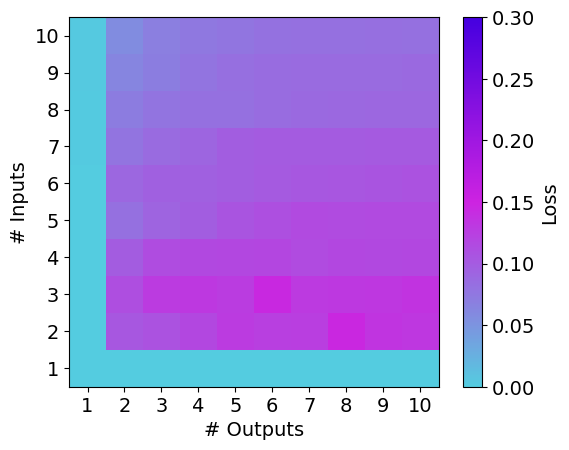

In [7]:
# Reload the module to reflect any changes made
importlib.reload(figure_plots)

figure_plots.loss_afo_in_out(norm_mean_loss, cmap)

In [10]:
norm_mean_loss

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.60737318e-16, 3.46063024e-16, 6.60390826e-16, 1.14926396e-16,
         8.19786689e-17, 8.41261231e-16, 8.61709963e-07, 8.09744115e-17],
        [1.04948752e-16, 5.50415307e-16, 1.49844009e-16, 1.76192627e-16,
         2.07735852e-16, 1.92579363e-16, 1.27147675e-06, 5.60883099e-16],
        [2.14418221e-16, 2.99912957e-16, 3.02667533e-16, 4.10358130e-16,
         2.66516096e-16, 1.74356063e-16, 1.22436299e-06, 2.89882383e-16],
        [1.18932967e-16, 3.62688792e-16, 4.14204469e-16, 3.65305529e-16,
         3.58507627e-16, 3.39183229e-16, 1.70954379e-07, 3.56313385e-16],
        [3.11272534e-16, 3.67988414e-16, 3.56975110e-16, 3.46613667e-16,
         3.23908212e-16, 9.10236169e-17, 1.79238756e-07, 3.50818219e-16],
        [5.17387367e-16, 4.31980595e-16, 3.98690983e-16, 5.65915943e-13,
         5.79872384e-16, 4.04149243e-16, 3.83

In [9]:
print(State.output)
print(State.desired)
print(State.loss)
print(np.sum(M_values_norm[:4]))
print(M_values_norm)

[0.55611156 0.48156366 0.49627211 0.69477514 0.44380396 0.38558426
 0.5541958  0.56212077 0.44742043 0.50555552]
[0.43794596 0.47129226 0.54273323 0.63008881 0.50020738 0.40827154
 0.51032338 0.65194519 0.46021822 0.51380493]
[[-0.1181656  -0.0102714   0.04646112 -0.06468633  0.05640341  0.02268728
  -0.04387242  0.08982442  0.01279779  0.0082494 ]]


NameError: name 'M_values_norm' is not defined

In [ ]:
# save_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/'
save_folder_prelim = 'C:/Users/roiee/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/'

np.save(save_folder_prelim + 'loss_mat.npy', norm_mean_loss)

In [ ]:
# print(norm_mean_loss)
# print(np.mean(norm_mean_loss, axis=2))
# np.std(norm_mean_loss, axis=2)

# norm_mean_loss with markers and no line
plt.plot(norm_mean_loss[:, 0], marker='o', linestyle='None')  # 'o' for circle markers, 'None' for no line

# Set y-axis to log scale
plt.yscale('log')

plt.legend(['Loss at final step'], loc='lower right')

# Set y-ticks every 1 unit (for log scale, this will display log-spaced ticks)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))

# Display the plot
plt.show()